In [1]:
import sklearn
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from rdkit.ML.Descriptors import MoleculeDescriptors
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
import seaborn as sn
from xgboost import XGBRFRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
dataset = pd.read_csv('delaney-processed.csv')
dataset.describe()

,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
count,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000
mean,-2.988192,1.058511,203.937074,0.701241,1.390957,2.177305,34.872881,-3.050102
std,1.683220,0.238560,102.738077,1.089727,1.318286,2.640974,35.383593,2.096441
min,-9.702000,0.000000,16.043000,0.000000,0.000000,0.000000,0.000000,-11.600000
25%,-3.948250,1.000000,121.183000,0.000000,0.000000,0.000000,0.000000,-4.317500
50%,-2.870000,1.000000,182.179000,0.000000,1.000000,1.000000,26.300000,-2.860000
75%,-1.843750,1.000000,270.372000,1.000000,2.000000,3.000000,55.440000,-1.600000
max,1.091000,2.000000,780.949000,11.000000,8.000000,23.000000,268.680000,1.580000


In [3]:
  X, y  = dataset['smiles'], dataset['measured log solubility in mols per litre']
    

In [4]:
X

0       OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1                                  Cc1occc1C(=O)Nc2ccccc2
2                                    CC(C)=CCCC(C)=CC(=O)
3                      c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4                                                 c1ccsc1
                              ...                        
1123                                     FC(F)(F)C(Cl)Br 
1124                            CNC(=O)ON=C(SC)C(=O)N(C)C
1125                                    CCSCCSP(=S)(OC)OC
1126                                              CCC(C)C
1127                COP(=O)(OC)OC(=CCl)c1cc(Cl)c(Cl)cc1Cl
Name: smiles, Length: 1128, dtype: object

In [5]:
y

0      -0.770
1      -3.300
2      -2.060
3      -7.870
4      -1.330
        ...  
1123   -1.710
1124    0.106
1125   -3.091
1126   -3.180
1127   -4.522
Name: measured log solubility in mols per litre, Length: 1128, dtype: float64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [7]:
train_morgan_fps = []
train_rd_fps = []
train_info=[]


for i in X_train:
    mol = Chem.MolFromSmiles(i) 
    info = {}
    temp = AllChem.GetMorganFingerprintAsBitVect(mol,2,2048,bitInfo=info)
    train_morgan_fps.append(temp)
    train_info.append(info)
    train_rd_fps.append(Chem.RDKFingerprint(mol))
   


In [8]:
test_morgan_fps = []
test_rd_fps = []
test_info=[]   
for j in X_test:
    mol = Chem.MolFromSmiles(j) 
    info = {}
    temp = AllChem.GetMorganFingerprintAsBitVect(mol,2,2048,bitInfo=info)
    test_morgan_fps.append(temp)
    test_info.append(info)
    test_rd_fps.append(Chem.RDKFingerprint(mol))
  
    

In [9]:
rf = RandomForestRegressor(random_state=42)


In [10]:
# Data preprocessing using pipeline 
pipe = Pipeline(steps=[
        ('scale', StandardScaler()),
        ('preprocessor', SimpleImputer()),
        ('model', rf)])

In [11]:
# Model Training and prediction
pipe.fit(train_morgan_fps,y_train) # training using 70% of the data
rf_prediction = pipe.predict(test_morgan_fps) # predicting yield for 30% of the data

In [12]:
#Model accuracy using root mean square error 
rmse = np.sqrt(mean_squared_error(y_test, rf_prediction)) 
print('rmse:', rmse)

rmse: 1.342872356772901


In [13]:
# Model Training and prediction
pipe.fit(train_rd_fps,y_train) # training using 70% of the data
rf_prediction_rd = pipe.predict(test_rd_fps) # predicting yield for 30% of the data

In [14]:
#Model accuracy using root mean square error 
rmse_rd = np.sqrt(mean_squared_error(y_test, rf_prediction_rd)) 
print('rmse_rd:', rmse_rd)

rmse_rd: 1.0017949136809765


In [15]:
# R^2 (coefficient of determination) regression score function: 
R2_rd =r2_score(y_test, rf_prediction_rd)
print('R^2:', R2_rd)

R^2: 0.7524811530145445


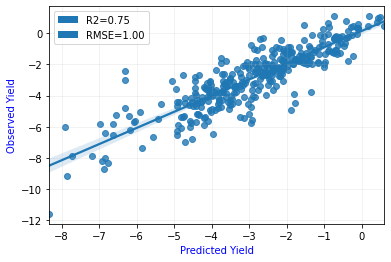

In [16]:
import matplotlib.patches as mpatches
sn.regplot(x=rf_prediction_rd, y=y_test)
plt.xlabel('Predicted Yield', color='blue')
plt.ylabel('Observed Yield', color ='blue')
plt.grid(alpha=0.2)
R2_rd = mpatches.Patch(label="R2={:04.2f}".format(R2_rd))
rmse_rd = mpatches.Patch(label="RMSE={:04.2f}".format(rmse_rd))
plt.legend(handles=[R2_rd, rmse_rd])

In [17]:
# R^2 (coefficient of determination) regression score function: 
R2 =r2_score(y_test, rf_prediction)
print('R^2:', R2)

R^2: 0.5552457606942302


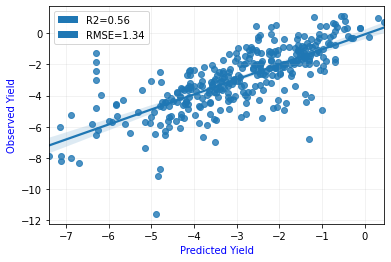

In [18]:
import matplotlib.patches as mpatches
sn.regplot(x=rf_prediction, y=y_test)
plt.xlabel('Predicted Yield', color='blue')
plt.ylabel('Observed Yield', color ='blue')
plt.grid(alpha=0.2)
R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
rmse = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
plt.legend(handles=[R2, rmse])

In [19]:
# XGBoost the most widely used ML model in kaggle competition
xgb = XGBRFRegressor(random_state = 42)

In [20]:
# Data preprocessing using pipeline 
pipe2 = Pipeline(steps=[
        ('scale', StandardScaler()),
        ('preprocessor', SimpleImputer()),
        ('model', xgb)])

In [21]:
pipe2.fit(train_morgan_fps,y_train)
xgb_prediction = pipe2.predict(test_morgan_fps)


In [22]:
# Model accuracy using root mean square error 
rmse2 = np.sqrt(mean_squared_error(y_test, xgb_prediction))  
print('rmse2:', rmse2)


rmse2: 1.6024462882782473


In [23]:

# R^2 (coefficient of determination) regression score function: 
R_2 =r2_score(y_test, xgb_prediction)
print('R^2:', R_2)

R^2: 0.3666881830701164


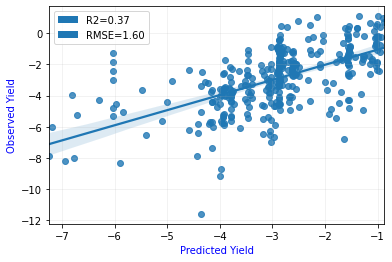

In [24]:
import matplotlib.patches as mpatches
sn.regplot(x=xgb_prediction, y=y_test)
plt.xlabel('Predicted Yield', color='blue')
plt.ylabel('Observed Yield', color ='blue')
plt.grid(alpha=0.2)
R_2 = mpatches.Patch(label="R2={:04.2f}".format(R_2))
rmse2 = mpatches.Patch(label="RMSE={:04.2f}".format(rmse2))
plt.legend(handles=[R_2, rmse2])